### Import modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

import discretize
from discretize import TensorMesh

In [5]:
from function import (
    plot_sounding,
    get_sounding_df
)

In [6]:
def plot_data(data_obj):
    plt.loglog(LM_times, -data_obj[src_lm, rx_lm])
    plt.loglog(HM_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        LM_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        HM_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )

### Load data from .csv

In [8]:
#please download data from "release" on the repository and rename the file_path below

file_path = "../../flight_line_101102_101201.csv"
file_path_all_data = "../../AusAEM_WA_Block_E_EM.csv"

df = pd.read_csv(file_path, 
                 delimiter=",") 

df_all = pd.read_csv(file_path_all_data, 
                 delimiter=",") 

# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_57148/1952385971.py:9: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(file_path_all_data,


In [9]:
# input flight line number and sounding ID
# 101102 or 101201
flightline = 101102 # or 101201

# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding = 7300 #7300

station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, sounding, df)

### Survey (Sounding-Independent)

1. Gate centre times

In [12]:
# load the gate opening time for LM and HM respectively
LM_excel = "../../LM_times.csv"
HM_excel = "../../HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [13]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

2. Waveform

In [15]:
LM_waveform_excel = "../../LM_waveform.csv"
HM_waveform_excel = "../../HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [16]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

3. Transmitter and Receiver Location

In [18]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([[-12.64,  -2.13,   0.  ],
                     [ -6.15,  -8.59,   0.  ],
                     [  5.74,  -8.59,   0.  ],
                     [ 11.13,  -3.19,   0.  ],
                     [ 11.13,   3.19,   0.  ],
                     [  5.74,   8.59,   0.  ],
                     [ -6.15,   8.59,   0.  ],
                     [-12.64,   2.13,   0.  ],
                     [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.46,   0.  ,  -2.  ]) # from data processing report

tx_area=342.0 # from data processing report

### Mesh Setup

In [20]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [21]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 29, 1.135)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 30 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     30          0.00        323.37      1.00     39.34    1.14

### Inversion

In [23]:
# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding_list = [7225,7100,6975,6850,6725,6600,6475,6350,6225,6100]#,5975,5625,5500]
# Initialize an empty list to store the data
data_list = []
# Initialize the list to store best-fit iterations
best_fit_iterations = []


In [24]:
# Pre-define parameters outside the loop that don't change
m_0 = np.log(1E-2)  # sigma = 1E-2 S/m
minimizer_params = {
    'maxIter': 30, 
    'maxIterLS': 20, 
    'maxIterCG': 10, 
    'tolCG': 1e-3
}

# Create a single instance of shared objects
empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=2)
save_dict = directives.SaveOutputDictEveryIteration()

In [25]:
# Initialize the list to store best-fit iterations
best_fit_iterations = []

# Process soundings
for i in sounding_list:
    try:
        # Extract sounding data
        station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, i, df)
        
        # Add UTM coordinates to transmitter shape and the receiver offset
        tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["Frame_Height"].iloc[0]]
        rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["Frame_Height"].iloc[0]]
        
        # Define source for survey input
        # Low moment:
        rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, LM_times, orientation='z')
        lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)
        src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)
        
        # High moment:
        rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, HM_times, orientation='z')
        hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)
        src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)
        
        # Define survey
        srv = tdem.Survey([src_lm, src_hm])
        
        # Observed data (normalized) & relative errors 
        dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
        #rel_err = np.r_[station_lm_std, station_hm_std]
        rel_err = np.full(41, 0.05) # 5% error
        data_container = data.Data(srv, dobs=dobs, relative_error=rel_err)
        
        # Halfspace Inversion
        sim_inv_halfspace = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)
        phi_d_halfspace = L2DataMisfit(data=data_container, simulation=sim_inv_halfspace)
        minimizer = optimization.InexactGaussNewton(maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3)
        inv_prob_halfspace = inverse_problem.BaseInvProblem(phi_d_halfspace, reg=empty_reg, opt=minimizer, beta=0.0)
        inv_halfspace = inversion.BaseInversion(inv_prob_halfspace, [])
        recovered_model = inv_halfspace.run(m_0)
        
        # Inversion Setup
        sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])
        phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)
        reg = regularization.WeightedLeastSquares(mesh)
        m_0_reg = np.full(mesh.n_cells, recovered_model[0])
        minimizer_reg = optimization.InexactGaussNewton(maxIter=50, maxIterLS=20, maxIterCG=10, tolCG=1e-5)
        inv_prob_3 = inverse_problem.BaseInvProblem(phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000)
        
        # Save output directive
        save_dict = directives.SaveOutputDictEveryIteration()
        inv3 = inversion.BaseInversion(inv_prob_3, [save_dict, beta_schedule])
        recovered_model_3 = inv3.run(m_0_reg)
        
        # Calculate predicted data
        data_pred_3 = sim_reg.make_synthetic_data(recovered_model_3)
        data_pred_3_2 = sim_reg.dpred(recovered_model_3)
        
        # Extract L-curve information
        n_iter = save_dict.opt.iter
        phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
        phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
        betas = [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

        best_fit_iter = 0
        
        # Check phi_d at iteration 48
        if phi_ds[48] < 100:
            # Use phi_ds[48] as reference
            phi_d_ref = phi_ds[48]
            phi_d_squared = phi_d_ref ** 2
            lower_bound = phi_d_squared * 0.1  # 10%
            upper_bound = phi_d_squared * 1.9  # 190%
        
            # Search for a valid iteration
            for j in range(1, n_iter - 1):
                if lower_bound <= phi_ds[j] <= upper_bound:
                    if j + 1 >= 8:
                        best_fit_iter = j + 1
                    else:
                        best_fit_iter = 12  # Reject if iteration is < 8
                    break
        else:
            # Fallback if phi_ds[48] >= 100
            best_fit_iter = 12

        # Append the best-fit iteration to the list
        best_fit_iterations.append(best_fit_iter)
        print(best_fit_iterations)
        
        # Save additional information
        sigmas = [sim_reg.sigma for _ in range(1, n_iter)]
        recovered_models = [save_dict.outDict[i]['m'] for i in range(1, n_iter)]
        predicted_datas = [data_pred_3 for _ in range(1, n_iter)]
        predicted_datas_2 = [data_pred_3_2 for _ in range(1, n_iter)]
        halfspace_conductivities = [sim_inv_halfspace.sigma for _ in range(1, n_iter)]
        
        # Collect data for the best fit iteration
        data_list.append({
            'Sounding': i,
            'Easting': station["Easting"].iloc[0],
            'Northing': station["Northing"].iloc[0],
            'DTM_AHD': station["DTM_AHD"].iloc[0],
            'Thicknesses': sim_reg.thicknesses.copy(),
            'Sigma': sigmas[best_fit_iter],
            'Recovered_Model': recovered_models[best_fit_iter],
            'Predicted_Data': predicted_datas[best_fit_iter],
            'Predicted_Data_2': predicted_datas_2[best_fit_iter],
            'Halfspace_Conductivity': halfspace_conductivities[best_fit_iter],
            'Observed_Data': dobs,

            # L-curve information
            'Phi_d': phi_ds[best_fit_iter],
            'Phi_m': phi_ms[best_fit_iter],
            'Betas': betas[best_fit_iter],
            'N_iterations': best_fit_iter,
            'All_Phi_d': phi_ds,
            'All_Phi_m': phi_ms,
            'All_Betas': betas
        })
        
    except Exception as e:
        print(f"Error processing sounding {i}: {e}")
        continue

# Now you have a list of best-fit iterations for each sounding
print(best_fit_iterations)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.17e+04  0.00e+00  1.17e+04    3.63e+03      0              
   1  0.00e+00  4.32e+03  6.71e+00  4.32e+03    9.08e+03      0              
   2  0.00e+00  2.63e+03  5.11e+00  2.63e+03    1.82e+03      0              
   3  0.00e+00  2.53e+03  4.70e+00  2.53e+03    3.44e+02      0   Skip BFGS  
   4  0.00e+00  2.52e+03  4.61e+00  2.52e+03    6.34e+01      0   Skip BFGS  
   5  0

/Applications/anaconda3/envs/simpeg-env/lib/python3.9/site-packages/simpeg/directives/directives.py:320: UserWarning: InversionDirective BetaSchedule has switched to a new inversion.
  d.inversion = i


   0  1.00e+04  7.00e+03  0.00e+00  7.00e+03    1.30e+03      0              
   1  1.00e+04  6.98e+03  1.01e-03  6.99e+03    6.04e+00      0              
   2  2.00e+03  6.98e+03  9.96e-04  6.99e+03    1.03e+03      0              
   3  2.00e+03  6.91e+03  2.26e-02  6.96e+03    2.07e+01      0              
   4  4.00e+02  6.91e+03  2.18e-02  6.92e+03    9.96e+02      0              
   5  4.00e+02  6.67e+03  3.79e-01  6.82e+03    5.82e+01      0              
   6  8.00e+01  6.68e+03  3.48e-01  6.71e+03    9.10e+02      0              
   7  8.00e+01  6.11e+03  4.20e+00  6.45e+03    1.21e+02      0              
   8  1.60e+01  6.09e+03  4.39e+00  6.16e+03    8.42e+02      0              
   9  1.60e+01  4.84e+03  3.86e+01  5.46e+03    3.18e+02      0              
  10  3.20e+00  4.53e+03  5.25e+01  4.70e+03    7.86e+02      0   Skip BFGS  
  11  3.20e+00  3.00e+03  2.13e+02  3.68e+03    4.40e+02      0              
  12  6.40e-01  2.29e+03  3.20e+02  2.49e+03    7.20e+02      0 

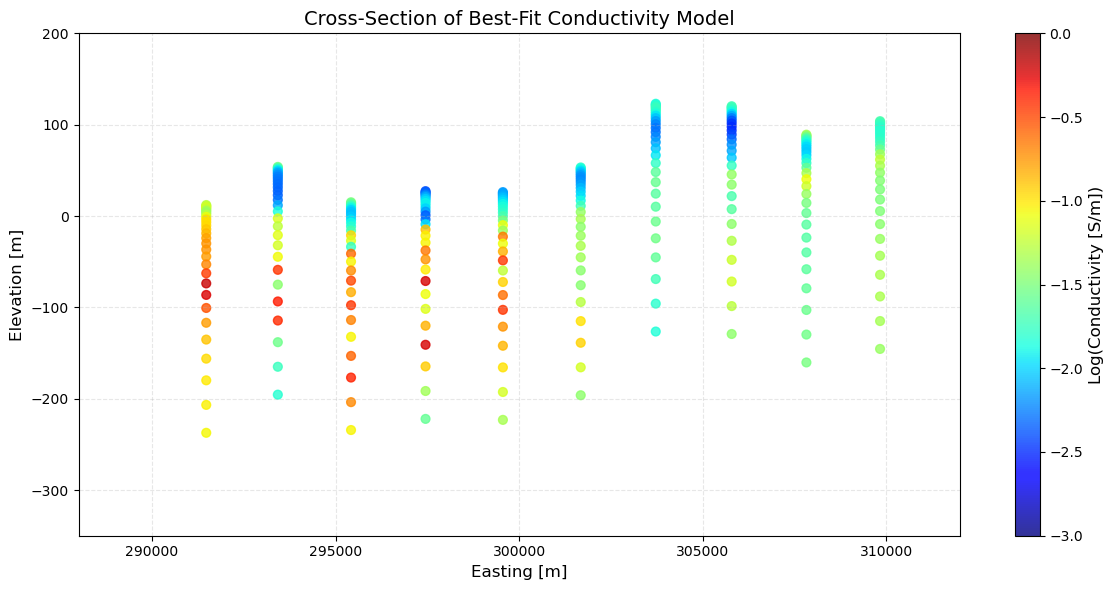

In [91]:
# Initialize lists to store data for plotting
easting_list = []
elevation_list = []
depth_list = []
sigma_list = []
recovered_model = []
model_values_list = []  # stores log10(exp_map * model)

# Process each entry in the data list (which now contains only best-fit iteration data)
for entry in data_list:
    easting = entry['Easting']
    thicknesses = entry['Thicknesses']
    sigma = entry['Sigma']
    DTM_AHD = entry['DTM_AHD']
    recovered_model = entry['Recovered_Model']
    recovered_model_array = np.array(recovered_model)
    
    # Compute top of each layer (depth from surface)
    layer_tops = np.concatenate(([0], np.cumsum(thicknesses[:-1])))  # length = num_layers
    elevation = DTM_AHD - layer_tops  # elevation of top of each layer

    # Ensure consistent length between model and measurements
    min_length = min(len(elevation), len(sigma), len(recovered_model_array))
    elevation = elevation[:min_length]
    sigma = sigma[:min_length]
    model = (exp_map * recovered_model_array)[:min_length]  # element-wise multiplication
    model_log = np.log10(model)

    # Extend lists for plotting
    easting_list.extend([easting] * min_length)
    elevation_list.extend(elevation)
    depth_list.extend(layer_tops[:min_length])
    sigma_list.extend(sigma)
    model_values_list.extend(model_log)

# Create the cross-section plot
plt.figure(figsize=(12, 6))

# Scatter plot colored by log conductivity
sc = plt.scatter(easting_list, elevation_list, c=model_values_list,
                 cmap='jet', vmin=-3, vmax=0, s=40, alpha=0.8)

# Add colorbar and labels
cbar = plt.colorbar(sc)
cbar.set_label('Log(Conductivity [S/m])', fontsize=12)
plt.xlabel('Easting [m]', fontsize=12)
plt.ylabel('Elevation [m]', fontsize=12)
plt.title('Cross-Section of Best-Fit Conductivity Model', fontsize=14)

# Set axis limits and add grid
plt.ylim([-350, 200])
plt.xlim([288000, 312000])
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

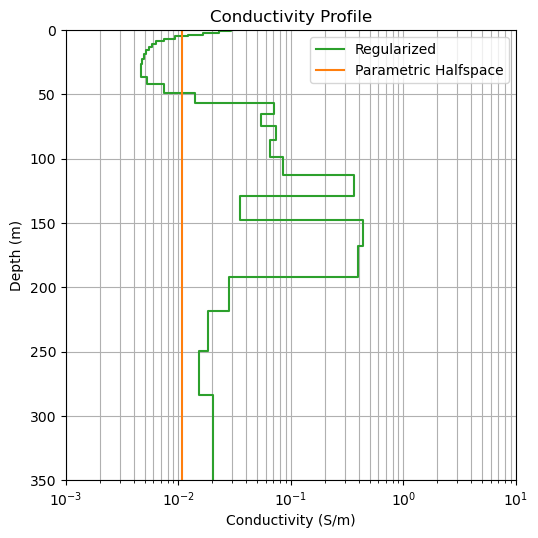

In [73]:
# Function to plot a specific sounding
def plot_sounding(index):
    entry = data_list[index]
    thicknesses = entry['Thicknesses']
    sigma = entry['Sigma']
    recovered_model = entry['Recovered_Model']
    halfspace_conductivity = entry['Halfspace_Conductivity']
    
    # Generate synthetic data
    # data_pre_3 = synthetic_data
    
    # Plot the 1D layer model
    ax = plot_1d_layer_model(thicknesses, exp_map * recovered_model, color='C2', label='Regularized')
    ax.set_xlabel("Conductivity (S/m)")
    ax.set_title("Conductivity Profile")
    ax.axvline(halfspace_conductivity, color='C1', label='Parametric Halfspace')
    ax.set_ylim([350, 0])
    ax.set_xlim([1E-3, 1E1])
    ax.grid(which="both")
    ax.legend()
    plt.show()

# Specify which sounding to plot (0, 1, or 2)
plot_sounding(1)# plot_sounding(1)  # Plot sounding 1
# plot_sounding(2)  # Plot sounding 2


In [75]:
def plot_data(index, y):
    entry = data_list[index]
    sounding = entry['Sounding']
    dobs = entry['Observed_Data']
    dpred = entry['Predicted_Data_2']
    
    # Assuming LM_times and HM_times are defined globally or passed as arguments
    plt.loglog(LM_times, -dobs[:18], label='lm dobs')
    plt.loglog(HM_times, -dobs[18:], label='hm dobs')
    
    plt.loglog(
        LM_times, -dpred[:18], color='C0', marker='x', linestyle="", label='lm dpred'
    )
    plt.loglog(
        HM_times, -dpred[18:], color='C1', marker='x', linestyle="", label='hm dpred'
    )
    plt.grid(which="both")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V/Am$^2$)')
    plt.title(y + ' for Sounding ' + str(sounding))
    plt.legend()
    plt.show()


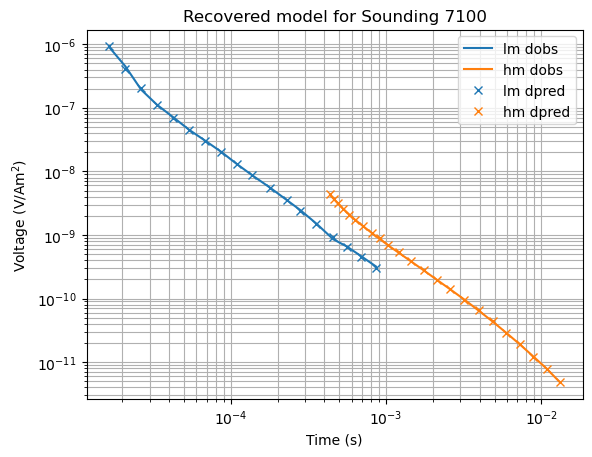

In [77]:
plot_data(1, 'Recovered model')

In [78]:
# Function to plot a specific sounding
def plot_phim_phid(index):
    entry = data_list[index]
    phids = entry['All_Phi_d']
    phims = entry['All_Phi_m']
    n_iter = entry['N_iterations']
    betas = entry['All_Betas']

    plt.scatter(phims, phids)
    plt.grid(which="both")
    plt.plot(phims[n_iter], phids[n_iter], marker='*', markersize=10, color='r')  # plot best fit iteration
    plt.xlabel("$\phi_m$")
    plt.ylabel("$\phi_d$")

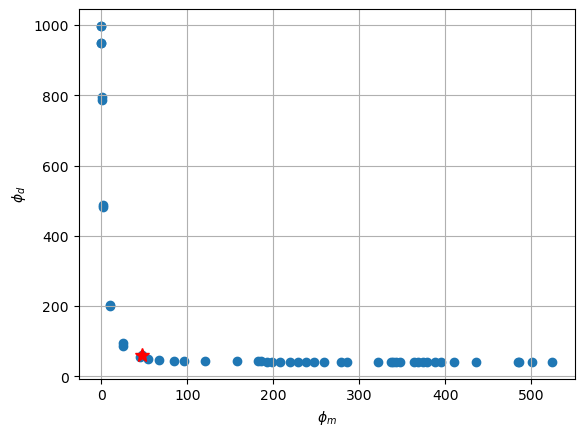

In [80]:
plot_phim_phid(8)